*柳明， Updated May 18th*

In [1]:
%matplotlib inline


NLP From Scratch: Translation with a Sequence to Sequence Network and Attention
*******************************************************************************
**Original Author**: `Sean Robertson <https://github.com/spro/practical-pytorch>`_

This is the third and final tutorial on doing "NLP From Scratch", where we
write our own classes and functions to preprocess the data to do our NLP
modeling tasks. We hope after you complete this tutorial that you'll proceed to
learn how `torchtext` can handle much of this preprocessing for you in the
three tutorials immediately following this one.

In this project we will be teaching a neural network to translate from
English to Chinese.

This is made possible by the simple but powerful idea of the `sequence
to sequence network <https://arxiv.org/abs/1409.3215>`__, in which two
recurrent neural networks work together to transform one sequence to
another. An encoder network condenses an input sequence into a vector,
and a decoder network unfolds that vector into a new sequence.

![](https://pytorch.org/tutorials/_images/seq2seq.png)

To improve upon this model we'll use an `attention
mechanism <https://arxiv.org/abs/1409.0473>`__, which lets the decoder
learn to focus over a specific range of the input sequence.

**Recommended Reading:**

I assume you have at least installed PyTorch, know Python, and
understand Tensors:

-  https://pytorch.org/ For installation instructions
-  :doc:`/beginner/deep_learning_60min_blitz` to get started with PyTorch in general
-  :doc:`/beginner/pytorch_with_examples` for a wide and deep overview
-  :doc:`/beginner/former_torchies_tutorial` if you are former Lua Torch user


It would also be useful to know about Sequence to Sequence networks and
how they work:

-  `Learning Phrase Representations using RNN Encoder-Decoder for
   Statistical Machine Translation <https://arxiv.org/abs/1406.1078>`__
-  `Sequence to Sequence Learning with Neural
   Networks <https://arxiv.org/abs/1409.3215>`__
-  `Neural Machine Translation by Jointly Learning to Align and
   Translate <https://arxiv.org/abs/1409.0473>`__
-  `A Neural Conversational Model <https://arxiv.org/abs/1506.05869>`__

You will also find the previous tutorials on
:doc:`/intermediate/char_rnn_classification_tutorial`
and :doc:`/intermediate/char_rnn_generation_tutorial`
helpful as those concepts are very similar to the Encoder and Decoder
models, respectively.

**Requirements**


In [2]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import jieba

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Loading data files
==================

The data for this project is a set of many thousands of English to
Chinese Mandarin translation pairs.

`This question on Open Data Stack
Exchange <https://opendata.stackexchange.com/questions/3888/dataset-of-sentences-translated-into-many-languages>`__
pointed me to the open translation site https://tatoeba.org/ which has
downloads available at https://tatoeba.org/eng/downloads - and better
yet, someone did the extra work of splitting language pairs into
individual text files here: https://www.manythings.org/anki/

The English to Chinese Mandarin pairs are too big to include in the repo, so
download to ``tchi_en_data/eng-cmn.txt`` before continuing. The file is a tab
separated list of translation pairs:



> Even now, I occasionally think I'd like to see you. Not the you that you are today, but the you I remember from the past.	
> 
> 即使是现在，我偶尔还是想见到你。不是今天的你，而是我记忆中曾经的你。



Similar to the character encoding used in the character-level RNN
tutorials, we will be representing each word in a language as a one-hot
vector, or giant vector of zeros except for a single one (at the index
of the word). Compared to the dozens of characters that might exist in a
language, there are many many more words, so the encoding vector is much
larger. We will however cheat a bit and trim the data to only use a few
thousand words per language.

![](https://pytorch.org/tutorials/_images/word-encoding.png)

We'll need a unique index per word to use as the inputs and targets of
the networks later. To keep track of all this we will use a helper class
called ``Lang`` which has word → index (``word2index``) and index → word
(``index2word``) dictionaries, as well as a count of each word
``word2count`` which will be used to replace rare words later.




In [3]:
SOS_token = 0
EOS_token = 1


class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        # TODO: Chinese word segmentation is different from languages like eng or fra
        if self.name == 'cmn':
            sentence = jieba.cut(sentence)
            sentence = ' '.join(sentence)

        for word in sentence.split(' '):
            self.addWord(word)

        # if Chinese, then return corresponding segmented squence
        # other language, just return the original one
        return sentence

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [4]:
# import jieba

# sent = "你應該請求你的老師允許。"
# seg_sent = jieba.cut(sent)
# seg_sent = ' '.join(seg_sent)

# for word in seg_sent.split(' '):
#     print(word)

The files are all in Unicode, to simplify we will turn Unicode
characters to ASCII, make everything lowercase, and trim most
punctuation.




In [5]:
# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

def normalizeChineseString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([。！？])", r" \1", s)
    # s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

In [6]:
normalizeString("知道了没有？"), normalizeChineseString("知道了没有？")

(' ', '知道了没有 ？')

To read the data file we will split the file into lines, and then split
lines into pairs. The files are all English → Other Language, so if we
want to translate from Other Language → English I added the ``reverse``
flag to reverse the pairs.




In [7]:
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('tchi_en_data/converted-%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[s for s in l.split('\t')[:2]] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

Since there are a *lot* of example sentences and we want to train
something quickly, we'll trim the data set to only relatively short and
simple sentences. Here the maximum length is 10 words (that includes
ending punctuation) and we're filtering to sentences that translate to
the form "I am" or "He is" etc. (accounting for apostrophes replaced
earlier).




In [8]:
MAX_LENGTH = 20

eng_prefixes = (
    "I am ", "I'm ",
    "He is", "He's ",
    "She is", "She's ",
    "You are", "You're ", "You'd ", "You should ", "You can ", "You don't ", "You didn't "
    "We are", "We're ",
    "They are", "They're ",
    "How ", "Who ", "What ", "Why ",
    "Do ", "Don't ", "Can ", "Did ",
    "If ", "As "
)


def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1]) < MAX_LENGTH and \
        p[0].startswith(eng_prefixes)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

The full process for preparing the data is:

-  Read text file and split into lines, split lines into pairs
-  Normalize text, filter by length and content
-  Make word lists from sentences in pairs




In [9]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse=False)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)

    for pair in pairs:
        pair[0] = normalizeString(pair[0]) 
        # pair[1] = normalizeChineseString(pair[1])

    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        in_sent = input_lang.addSentence(pair[0])
        pair[0] = in_sent
        out_sent = output_lang.addSentence(pair[1])
        pair[1] = out_sent
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepareData('eng', 'cmn', True)
print(random.choice(pairs))

Reading lines...


Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache


Read 29155 sentence pairs
Trimmed to 5346 sentence pairs
Counting words...


Loading model cost 2.366 seconds.
Prefix dict has been built successfully.


Counted words:
eng 2467
cmn 3533
['i m going to meet him tomorrow .', '我 明天 要 跟 他 见面 。']


In [10]:
len(pairs), output_lang.name, output_lang.index2word

(5346,
 'cmn',
 {0: 'SOS',
  1: 'EOS',
  2: '我',
  3: '没事',
  4: '。',
  5: '已经',
  6: '起来',
  7: '了',
  8: '为什么',
  9: '是',
  10: '？',
  11: '觉得',
  12: '很',
  13: '热',
  14: '生病',
  15: '难过',
  16: '害羞',
  17: '湿',
  18: '谁',
  19: '赢',
  20: '不',
  21: '多',
  22: '可爱',
  23: '啊',
  24: '！',
  25: '回来',
  26: '忙',
  27: '冷',
  28: '很酷',
  29: '好',
  30: '自由',
  31: '吃饱',
  32: '在',
  33: '家里',
  34: '迷失',
  35: '我病',
  36: '个子',
  37: '高',
  38: '死',
  39: '现在',
  40: '就',
  41: '做',
  42: '别哭',
  43: '他',
  44: '一个',
  45: '',
  46: 'DJ',
  47: '懒',
  48: '太',
  49: '可怕',
  50: '真',
  51: '奇怪',
  52: '多怪',
  53: '个',
  54: '男人',
  55: '无聊',
  56: '第一',
  57: '运气',
  58: '对',
  59: '的',
  60: '清醒',
  61: '对不起',
  62: '抱歉',
  63: '累',
  64: '还',
  65: '年轻',
  66: '爱',
  67: '知道',
  68: '可以',
  69: '帮忙',
  70: '吗',
  71: '?',
  72: '别',
  73: '担心',
  74: '别动',
  75: '不要',
  76: '动',
  77: '.',
  78: '等待',
  79: '凶',
  80: '很穷',
  81: '个头',
  82: '矮',
  83: '30',
  84: '岁',
  85: '英雄',
 

The Seq2Seq Model
=================

A Recurrent Neural Network, or RNN, is a network that operates on a
sequence and uses its own output as input for subsequent steps.

A `Sequence to Sequence network <https://arxiv.org/abs/1409.3215>`__, or
seq2seq network, or `Encoder Decoder
network <https://arxiv.org/pdf/1406.1078v3.pdf>`__, is a model
consisting of two RNNs called the encoder and decoder. The encoder reads
an input sequence and outputs a single vector, and the decoder reads
that vector to produce an output sequence.


![](https://pytorch.org/tutorials/_images/seq2seq.png)

Unlike sequence prediction with a single RNN, where every input
corresponds to an output, the seq2seq model frees us from sequence
length and order, which makes it ideal for translation between two
languages.

Consider the sentence "Je ne suis pas le chat noir" → "I am not the
black cat". Most of the words in the input sentence have a direct
translation in the output sentence, but are in slightly different
orders, e.g. "chat noir" and "black cat". Because of the "ne/pas"
construction there is also one more word in the input sentence. It would
be difficult to produce a correct translation directly from the sequence
of input words.

With a seq2seq model the encoder creates a single vector which, in the
ideal case, encodes the "meaning" of the input sequence into a single
vector — a single point in some N dimensional space of sentences.




The Encoder
-----------

The encoder of a seq2seq network is a RNN that outputs some value for
every word from the input sentence. For every input word the encoder
outputs a vector and a hidden state, and uses the hidden state for the
next input word.


![](https://pytorch.org/tutorials/_images/encoder-network.png)


In [11]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

The Decoder
-----------

The decoder is another RNN that takes the encoder output vector(s) and
outputs a sequence of words to create the translation.




**Simple Decoder**


In the simplest seq2seq decoder we use only last output of the encoder.
This last output is sometimes called the *context vector* as it encodes
context from the entire sequence. This context vector is used as the
initial hidden state of the decoder.

At every step of decoding, the decoder is given an input token and
hidden state. The initial input token is the start-of-string ``<SOS>``
token, and the first hidden state is the context vector (the encoder's
last hidden state).


![](https://pytorch.org/tutorials/_images/decoder-network.png)


In [12]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

I encourage you to train and observe the results of this model, but to
save space we'll be going straight for the gold and introducing the
Attention Mechanism.




**Attention Decoder**

If only the context vector is passed between the encoder and decoder,
that single vector carries the burden of encoding the entire sentence.

Attention allows the decoder network to "focus" on a different part of
the encoder's outputs for every step of the decoder's own outputs. First
we calculate a set of *attention weights*. These will be multiplied by
the encoder output vectors to create a weighted combination. The result
(called ``attn_applied`` in the code) should contain information about
that specific part of the input sequence, and thus help the decoder
choose the right output words.

Calculating the attention weights is done with another feed-forward
layer ``attn``, using the decoder's input and hidden state as inputs.
Because there are sentences of all sizes in the training data, to
actually create and train this layer we have to choose a maximum
sentence length (input length, for encoder outputs) that it can apply
to. Sentences of the maximum length will use all the attention weights,
while shorter sentences will only use the first few.

![](https://pytorch.org/tutorials/_images/attention-decoder-network.png)


In [13]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

<div class="alert alert-info"><h4>Note</h4><p>There are other forms of attention that work around the length
  limitation by using a relative position approach. Read about "local
  attention" in `Effective Approaches to Attention-based Neural Machine
  Translation <https://arxiv.org/abs/1508.04025>`__.</p></div>

Training
========

Preparing Training Data
-----------------------

To train, for each pair we will need an input tensor (indexes of the
words in the input sentence) and target tensor (indexes of the words in
the target sentence). While creating these vectors we will append the
EOS token to both sequences.




In [14]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

Training the Model
------------------

To train we run the input sentence through the encoder, and keep track
of every output and the latest hidden state. Then the decoder is given
the ``<SOS>`` token as its first input, and the last hidden state of the
encoder as its first hidden state.

"Teacher forcing" is the concept of using the real target outputs as
each next input, instead of using the decoder's guess as the next input.
Using teacher forcing causes it to converge faster but `when the trained
network is exploited, it may exhibit
instability <http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.378.4095&rep=rep1&type=pdf>`__.

You can observe outputs of teacher-forced networks that read with
coherent grammar but wander far from the correct translation -
intuitively it has learned to represent the output grammar and can "pick
up" the meaning once the teacher tells it the first few words, but it
has not properly learned how to create the sentence from the translation
in the first place.

Because of the freedom PyTorch's autograd gives us, we can randomly
choose to use teacher forcing or not with a simple if statement. Turn
``teacher_forcing_ratio`` up to use more of it.




In [15]:
teacher_forcing_ratio = 0.5

def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

This is a helper function to print time elapsed and estimated time
remaining given the current time and progress %.




In [16]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

The whole training process looks like this:

-  Start a timer
-  Initialize optimizers and criterion
-  Create set of training pairs
-  Start empty losses array for plotting

Then we call ``train`` many times and occasionally print the progress (%
of examples, time so far, estimated time) and average loss.




Plotting results
----------------

Plotting is done with matplotlib, using the array of loss values
``plot_losses`` saved while training.


In [17]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [18]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    # encoder_optimizer = optim.AdamW(encoder.parameters(), lr=learning_rate)
    # decoder_optimizer = optim.AdamW(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

Evaluation
==========

Evaluation is mostly the same as training, but there are no targets so
we simply feed the decoder's predictions back to itself for each step.
Every time it predicts a word we add it to the output string, and if it
predicts the EOS token we stop there. We also store the decoder's
attention outputs for display later.




In [19]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

We can evaluate random sentences from the training set and print out the
input, target, and output to make some subjective quality judgements:




In [20]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

Training and Evaluating
=======================

With all these helper functions in place (it looks like extra work, but
it makes it easier to run multiple experiments) we can actually
initialize a network and start training.

Remember that the input sentences were heavily filtered. For this small
dataset we can use relatively small networks of 256 hidden nodes and a
single GRU layer. After about 40 minutes on a MacBook CPU we'll get some
reasonable results.

.. Note::
   If you run this notebook you can train, interrupt the kernel,
   evaluate, and continue training later. Comment out the lines where the
   encoder and decoder are initialized and run ``trainIters`` again.




1m 59s (- 72m 51s) (2000 2%) 4.2631
3m 42s (- 65m 51s) (4000 5%) 3.9113
4m 47s (- 55m 1s) (6000 8%) 3.6767
5m 45s (- 48m 10s) (8000 10%) 3.4167
6m 42s (- 43m 36s) (10000 13%) 3.2349
7m 40s (- 40m 16s) (12000 16%) 3.0506
8m 38s (- 37m 39s) (14000 18%) 2.8579
9m 36s (- 35m 27s) (16000 21%) 2.6945
10m 35s (- 33m 33s) (18000 24%) 2.5190
11m 35s (- 31m 52s) (20000 26%) 2.3870
12m 53s (- 31m 2s) (22000 29%) 2.2694
14m 27s (- 30m 44s) (24000 32%) 2.1184
16m 0s (- 30m 10s) (26000 34%) 2.0164
17m 33s (- 29m 28s) (28000 37%) 1.9421
19m 5s (- 28m 38s) (30000 40%) 1.8208
20m 36s (- 27m 41s) (32000 42%) 1.7037
22m 9s (- 26m 43s) (34000 45%) 1.5775
23m 10s (- 25m 6s) (36000 48%) 1.4880
24m 10s (- 23m 31s) (38000 50%) 1.4081
25m 8s (- 22m 0s) (40000 53%) 1.3287
26m 6s (- 20m 31s) (42000 56%) 1.2640
27m 6s (- 19m 5s) (44000 58%) 1.2284
28m 5s (- 17m 42s) (46000 61%) 1.1851
29m 4s (- 16m 21s) (48000 64%) 1.0788
30m 3s (- 15m 1s) (50000 66%) 1.0077
31m 27s (- 13m 54s) (52000 69%) 1.0107
33m 0s (- 12m 50

<Figure size 432x288 with 0 Axes>

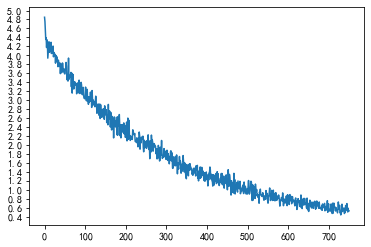

In [21]:
%matplotlib inline

hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

trainIters(encoder1, attn_decoder1, 75000, print_every=2000)

In [26]:
evaluateRandomly(encoder1, attn_decoder1)

> what kind of shampoo do you use ?
= 你 用 哪种 洗发水 ？
< 你 用 哪种 洗发水 ？ <EOS>

> you don t need to help me .
= 你 不用 帮 我 。
< 你 不用 帮 我 。 <EOS>

> what are you eating ?
= 在 吃 什么 呢 ？
< 在 吃 什么 呢 ？ <EOS>

> how many rackets do you have ?
= 你 有 多少 支 球拍 ?
< 你 有 多少 支 ？ <EOS>

> you don t have to answer right away .
= 你 不用 马上 回答 。
< 你 不用 马上 回答 。 <EOS>

> what do you suppose this could be ?
= 你 认为 这是 什么 ？
< 你 认为 这是 什么 ？ <EOS>

> did you read the article ?
= 你 看 文章 了 没 ？
< 你 看 门 吗 ？ <EOS>

> why didn t you dance with him ?
= 你 为什么 不 跟 他 跳舞 呢 ？
< 你 为什么 不 跟 他 跳舞 ？ <EOS>

> how about calling it a day ?
= 今天 就 做到 这里 如何 ?
< 今天 就 做到 这里 如何 ? <EOS>

> did you buy a round trip ticket ?
= 你 买 了 往返 的 票 吗 ？
< 你 买 了 往返 的 票 吗 ？ <EOS>



Visualizing Attention
---------------------

A useful property of the attention mechanism is its highly interpretable
outputs. Because it is used to weight specific encoder outputs of the
input sequence, we can imagine looking where the network is focused most
at each time step.

You could simply run ``plt.matshow(attentions)`` to see attention output
displayed as a matrix, with the columns being input steps and rows being
output steps:




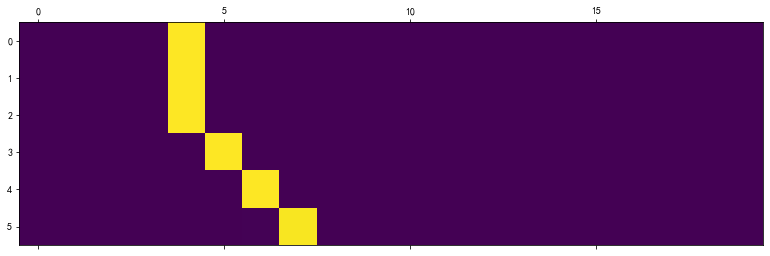

In [28]:
%matplotlib inline

output_words, attentions = evaluate(
    encoder1, attn_decoder1, "what do you suppose this could be ?")
plt.matshow(attentions.numpy())

For a better viewing experience we will do the extra work of adding axes
and labels:




In [29]:
import matplotlib as mpl
mpl.rcdefaults() 

def showAttention(input_sentence, output_words, attentions):
    mpl.rcParams['font.family'] = 'SimHei'
    # Set up figure with colorbar
    fig = plt.figure(figsize=(9, 5))
    
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words, family='SimHei')

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(
        encoder1, attn_decoder1, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)

input = what kind of shampoo do you use ?
output = 你 用 哪种 洗发水 ？ <EOS>


/tmp/ipykernel_17622/2634899092.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + input_sentence.split(' ') +
/tmp/ipykernel_17622/2634899092.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + output_words, family='SimHei')


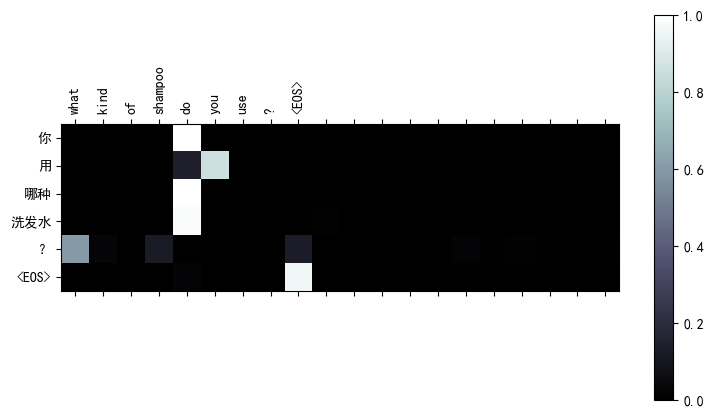

input = what are you eating ?
output = 在 吃 什么 呢 ？ <EOS>


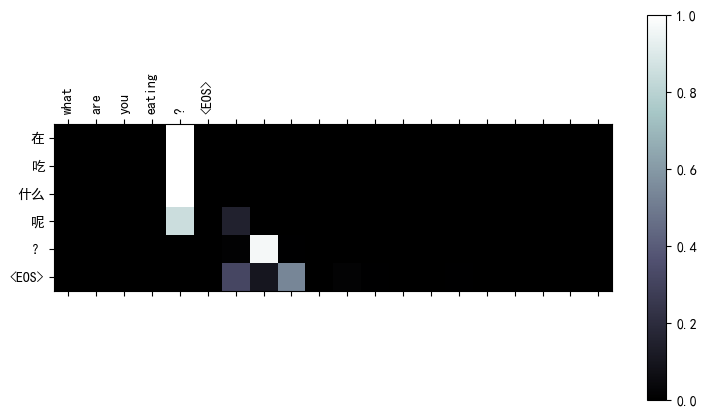

input = why didn t you dance with him ?
output = 你 为什么 不 跟 他 跳舞 ？ <EOS>


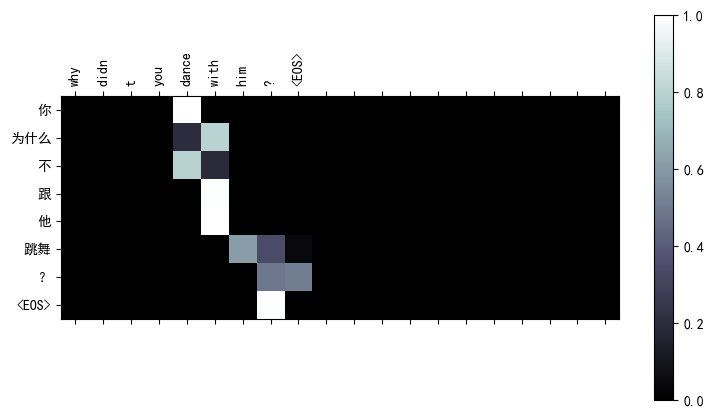

input = did you buy a round trip ticket ?
output = 你 买 了 往返 的 票 吗 ？ <EOS>


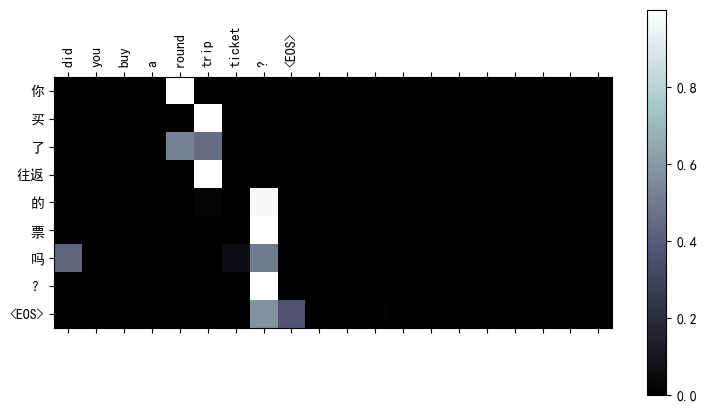

In [30]:
evaluateAndShowAttention("what kind of shampoo do you use ?")
evaluateAndShowAttention("what are you eating ?")
evaluateAndShowAttention("why didn t you dance with him ?")
evaluateAndShowAttention("did you buy a round trip ticket ?")